In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

# 1. Load Data
df = pd.read_csv('Indian_Food_Nutrition_Processed.csv')
df['Vitamin C (mg)'] = df['Vitamin C (mg)'].fillna(df['Vitamin C (mg)'].median())
df['Folate (µg)'] = df['Folate (µg)'].fillna(df['Folate (µg)'].median())

# ==========================================
# 2. Feature Engineering: NRF 5.3 (Scientific Health Score)
# ==========================================
# สร้าง Binary Tags เดิม
df['High_Protein'] = (df['Protein (g)'] > 10).astype(int)
df['Low_Carb'] = (df['Carbohydrates (g)'] < 15).astype(int)
df['Low_Calorie'] = (df['Calories (kcal)'] < 150).astype(int)

# --- สูตร Health Score ใหม่ (NRF Index Concept) ---
# คำนวณ % Daily Value ของสารอาหารดี (Positive)
# สูตร: (ปริมาณที่มี / เป้าหมายต่อวัน) * 100
p_protein = (df['Protein (g)'] / 50) * 100
p_fiber = (df['Fibre (g)'] / 28) * 100
p_vitc = (df['Vitamin C (mg)'] / 90) * 100
p_calcium = (df['Calcium (mg)'] / 1300) * 100
p_iron = (df['Iron (mg)'] / 18) * 100

# คำนวณ % Daily Value ของสารอาหารที่ต้องระวัง (Negative)
n_sugar = (df['Free Sugar (g)'] / 50) * 100
n_fat = (df['Fats (g)'] / 78) * 100
n_sodium = (df['Sodium (mg)'] / 2300) * 100

# รวมคะแนน (สารอาหารดี - สารอาหารร้าย)
# ยิ่งคะแนนมาก = ยิ่งสารอาหารหนาแน่นและดีต่อสุขภาพ
df['Health_Score'] = (p_protein + p_fiber + p_vitc + p_calcium + p_iron) - (n_sugar + n_fat + n_sodium)

# ==========================================
# 3. Clustering & Model (เหมือนเดิม)
# ==========================================
numerical_features = ['Calories (kcal)', 'Carbohydrates (g)', 'Protein (g)', 'Fats (g)', 
                      'Free Sugar (g)', 'Fibre (g)', 'Sodium (mg)', 'Calcium (mg)', 
                      'Iron (mg)', 'Vitamin C (mg)', 'Folate (µg)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numerical_features])

kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_means = df.groupby('Cluster')[numerical_features].mean()
cluster_names = {}
for i, row in cluster_means.iterrows():
    if row['Free Sugar (g)'] > 15:
        name = "🍭 Sweet/Dessert"
    elif row['Fats (g)'] > 20:
        name = "🧀 Rich/High Fat"
    elif row['Protein (g)'] > 15:
        name = "💪 High Protein"
    elif row['Calories (kcal)'] < 150:
        name = "🥗 Light/Snack"
    else:
        name = "🍛 Balanced Meal"
    cluster_names[i] = name
df['Category'] = df['Cluster'].map(cluster_names)

knn = NearestNeighbors(n_neighbors=10, metric='euclidean')
knn.fit(X_scaled)

# ==========================================
# 4. Updated Function (เพิ่มการแสดง Health Score)
# ==========================================
def smart_recommendation_final(query_input, n_recommendations=5):
    input_vector = None
    start_idx = 0
    
    name_map = {
        'Calories': 'Calories (kcal)', 'Cal': 'Calories (kcal)',
        'Carbohydrates': 'Carbohydrates (g)', 'Carb': 'Carbohydrates (g)', 'Carbs': 'Carbohydrates (g)',
        'Protein': 'Protein (g)', 'Pro': 'Protein (g)',
        'Fats': 'Fats (g)', 'Fat': 'Fats (g)',
        'Sugar': 'Free Sugar (g)', 'Free Sugar': 'Free Sugar (g)',
        'Fibre': 'Fibre (g)', 'Fiber': 'Fibre (g)',
        'Sodium': 'Sodium (mg)', 'Salt': 'Sodium (mg)',
        'Calcium': 'Calcium (mg)',
        'Iron': 'Iron (mg)',
        'Vitamin C': 'Vitamin C (mg)', 'Vit C': 'Vitamin C (mg)',
        'Folate': 'Folate (µg)'
    }

    if isinstance(query_input, str):
        matches = df[df['Dish Name'].str.contains(query_input, case=False, na=False)]
        if matches.empty: return f"❌ Error: ไม่พบเมนูชื่อ '{query_input}'"
        
        target_idx = matches.index[0]
        target_row = matches.iloc[0]
        
        is_hp = "✅ Yes" if target_row['High_Protein'] else "❌ No"
        is_lc = "✅ Yes" if target_row['Low_Carb'] else "❌ No"
        is_lcal = "✅ Yes" if target_row['Low_Calorie'] else "❌ No"

        # แสดงผลเมนูที่เลือก พร้อม Health Score
        print(f"\n🔍 Selected Dish: {target_row['Dish Name']}")
        print(f"   Category:     {target_row['Category']}")
        print(f"   Health Score: {round(target_row['Health_Score'], 2)} (คะแนน NRF ยิ่งเยอะยิ่งดี)")
        print(f"   High Protein: {is_hp} | Low Carb: {is_lc} | Low Cal: {is_lcal}")
        print("-" * 50)
        print(f"   Calories: {int(target_row['Calories (kcal)'])} kcal")
        print(f"   Protein:  {target_row['Protein (g)']} g")
        print(f"   Fat:      {target_row['Fats (g)']} g")
        print(f"   Carbs:    {target_row['Carbohydrates (g)']} g")
        print(f"   Sugar:    {target_row['Free Sugar (g)']} g")
        print(f"   Sodium:   {target_row['Sodium (mg)']} mg")
        print("-" * 50 + "\n")
        
        input_vector = X_scaled[target_idx].reshape(1, -1)
        start_idx = 1

    elif isinstance(query_input, dict):
        print(f"🎯 Targeting Nutrients: {query_input}")
        base_vector = df[numerical_features].mean().values
        col_map = {col: i for i, col in enumerate(numerical_features)}
        for key, val in query_input.items():
            target_col = name_map.get(key, key)
            if target_col in col_map:
                base_vector[col_map[target_col]] = val
        input_df = pd.DataFrame([base_vector], columns=numerical_features)
        input_vector = scaler.transform(input_df)
        start_idx = 0
    else:
        return "❌ Error: Invalid Input"

    distances, indices = knn.kneighbors(input_vector, n_neighbors=n_recommendations + 1 + start_idx)
    
    results = []
    for i in range(start_idx, len(indices[0])):
        idx = indices[0][i]
        dist = distances[0][i]
        row = df.iloc[idx]
        
        similarity_pct = 100 * (1 / (1 + dist))
        
        hp_tag = "✅ Yes" if row['High_Protein'] == 1 else "❌ No"
        lc_tag = "✅ Yes" if row['Low_Carb'] == 1 else "❌ No"
        lcal_tag = "✅ Yes" if row['Low_Calorie'] == 1 else "❌ No"
        
        item = {
            'Dish Name': row['Dish Name'],
            'Category': row['Category'],
            'Match (%)': f"{similarity_pct:.1f}%",
            'Health Score': round(row['Health_Score'], 2), # <--- เพิ่มตรงนี้ครับ!
            'High Protein?': hp_tag,
            'Low Carb?': lc_tag,
            'Low Calorie?': lcal_tag,
            'Calories': int(row['Calories (kcal)']),
            'Protein (g)': round(row['Protein (g)'], 1),
            'Carb (g)': round(row['Carbohydrates (g)'], 1),
            'Fat (g)': round(row['Fats (g)'], 1),
            'Sugar (g)': round(row['Free Sugar (g)'], 1),
            'Sodium (mg)': int(row['Sodium (mg)']),
        }
        results.append(item)
        
    return pd.DataFrame(results)

# --- ทดสอบ ---
print("\n--- Test 1: ค้นหาจากชื่อเมนู 'Butter Chicken' ---")
print(smart_recommendation_final('Butter Chicken'))

print("\n--- Test 2: ค้นหาเมนูคลีน ---")
target = {'Calories': 100, 'Carb': 5, 'Protein': 20}
print(smart_recommendation_final(target))


--- Test 1: ค้นหาจากชื่อเมนู 'Butter Chicken' ---

🔍 Selected Dish: Butter chicken
   Category:     🥗 Light/Snack
   Health Score: 52.85 (คะแนน NRF ยิ่งเยอะยิ่งดี)
   High Protein: ✅ Yes | Low Carb: ✅ Yes | Low Cal: ✅ Yes
--------------------------------------------------
   Calories: 137 kcal
   Protein:  10.92 g
   Fat:      8.7 g
   Carbs:    3.74 g
   Sugar:    2.37 g
   Sodium:   26.21 mg
--------------------------------------------------

                   Dish Name       Category Match (%)  Health Score  \
0             Tomato chicken  🥗 Light/Snack     65.7%         44.91   
1              Chicken curry  🥗 Light/Snack     59.6%         36.22   
2                   Fish pie  🥗 Light/Snack     57.5%         42.49   
3              Tandoori fish  🥗 Light/Snack     55.9%         37.18   
4  Fish curry (Machli curry)  🥗 Light/Snack     52.8%         38.66   
5          Crispy baked fish  🥗 Light/Snack     51.9%         33.11   

  High Protein? Low Carb? Low Calorie?  Calories  Pr

c:\Users\realr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


--- สัดส่วนเกรดอาหารใน Dataset (เรียงตามเกรด) ---
Grade
A (Healthy)     129
B (Moderate)    459
C (Limit)       426
Name: count, dtype: int64

📊 Classification Report
              precision    recall  f1-score   support

 A (Healthy)       1.00      0.92      0.96        26
B (Moderate)       0.96      1.00      0.98        92
   C (Limit)       1.00      0.98      0.99        85

    accuracy                           0.98       203
   macro avg       0.99      0.97      0.98       203
weighted avg       0.98      0.98      0.98       203



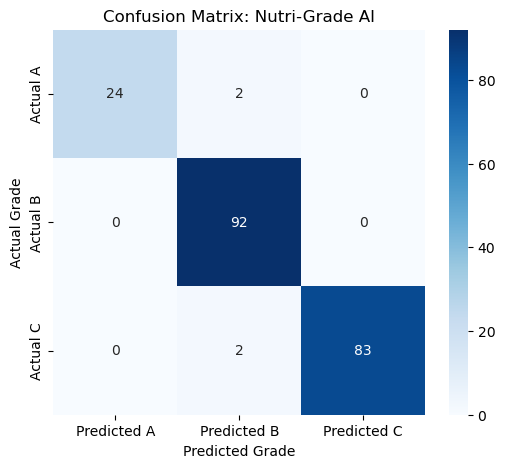

C:\Users\realr\AppData\Local\Temp\ipykernel_17228\2029008724.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


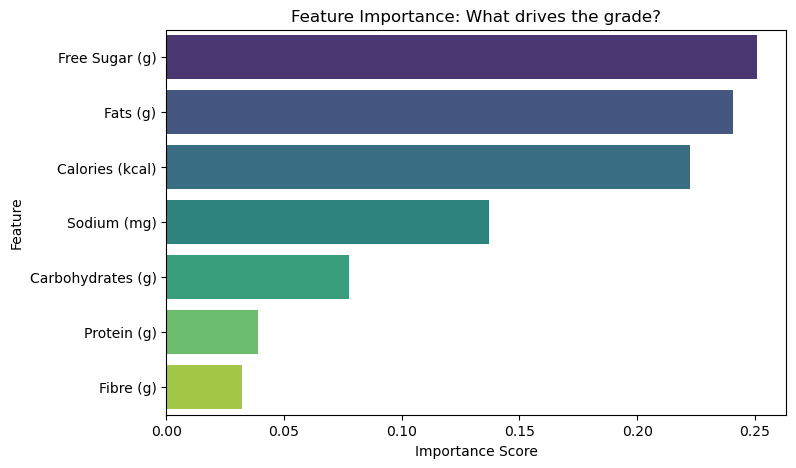


--- 🧪 ทดสอบ AI ตัดเกรด ---
Input: Sugar 0.88g, Fat 67.76g, Sodium 108.61mg  -->  Grade: C (Limit) (Confidence: 100.00%)
Input: Sugar 8.9g, Fat 30g, Sodium 300mg  -->  Grade: C (Limit) (Confidence: 96.00%)
Input: Sugar 8g, Fat 12g, Sodium 400mg  -->  Grade: B (Moderate) (Confidence: 100.00%)


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load Data
df = pd.read_csv('Indian_Food_Nutrition_Processed.csv')
# Fill missing values
df['Vitamin C (mg)'] = df['Vitamin C (mg)'].fillna(df['Vitamin C (mg)'].median())
df['Folate (µg)'] = df['Folate (µg)'].fillna(df['Folate (µg)'].median())

# ==========================================
# Step 1: สร้าง Label (Nutri-Grade) ตามหลักโภชนาการ
# ==========================================
def assign_grade(row):
    # เกณฑ์สำหรับ Grade C (ควรเลี่ยง): น้ำตาล > 15g หรือ ไขมัน > 20g หรือ โซเดียม > 600mg
    if row['Free Sugar (g)'] > 15 or row['Fats (g)'] > 20 or row['Sodium (mg)'] > 600:
        return 'C (Limit)'
    # เกณฑ์สำหรับ Grade A (สุขภาพดี): น้ำตาล < 5g และ ไขมัน < 5g และ โซเดียม < 200mg
    elif row['Free Sugar (g)'] < 5 and row['Fats (g)'] < 5 and row['Sodium (mg)'] < 200:
        return 'A (Healthy)'
    # ที่เหลือคือ Grade B (ปานกลาง)
    else:
        return 'B (Moderate)'

df['Grade'] = df.apply(assign_grade, axis=1)

print("--- สัดส่วนเกรดอาหารใน Dataset (เรียงตามเกรด) ---")
print(df['Grade'].value_counts().reindex(['A (Healthy)', 'B (Moderate)', 'C (Limit)']))

# ==========================================
# Step 2: Prepare Data & Train Model
# ==========================================
# Features ที่ใช้ทำนาย
features = ['Calories (kcal)', 'Carbohydrates (g)', 'Protein (g)', 'Fats (g)', 
            'Free Sugar (g)', 'Fibre (g)', 'Sodium (mg)']

X = df[features]
y = df['Grade']

# แบ่ง Train 80% / Test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# สร้างโมเดล Classification (Random Forest)
clf_model = RandomForestClassifier(n_estimators=100, random_state=42)
clf_model.fit(X_train, y_train)

# ==========================================
# Step 3: Evaluation (วัดผล)
# ==========================================
y_pred = clf_model.predict(X_test)

print("\n" + "="*40)
print("📊 Classification Report")
print("="*40)
print(classification_report(y_test, y_pred))

# แสดง Confusion Matrix (ดูว่าทายผิดไปลงช่องไหนบ้าง)
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred, labels=['A (Healthy)', 'B (Moderate)', 'C (Limit)'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted A', 'Predicted B', 'Predicted C'],
            yticklabels=['Actual A', 'Actual B', 'Actual C'])
plt.title('Confusion Matrix: Nutri-Grade AI')
plt.ylabel('Actual Grade')
plt.xlabel('Predicted Grade')
plt.show()

# ==========================================
# Step 4: Feature Importance (ไฮไลท์ของโปรเจคนี้)
# ==========================================
# ดูว่าสารอาหารตัวไหนมีผลต่อการตัดเกรดมากที่สุด
importances = clf_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Feature Importance: What drives the grade?')
plt.xlabel('Importance Score')
plt.show()

# ==========================================
# Step 5: Test Prediction (ลองใช้งานจริง)
# ==========================================
# แก้ไขฟังก์ชันทดสอบให้คำนวณแคลอรี่เองเบื้องต้น
def predict_health_grade(sugar, fat, sodium):
    # ใช้ค่าเฉลี่ยสำหรับตัวที่ไม่รู้ (Protein, Carb, Fiber)
    avg_protein = df['Protein (g)'].mean()
    avg_carb = df['Carbohydrates (g)'].mean()
    avg_fiber = df['Fibre (g)'].mean()
    
    # คำนวณแคลอรี่แบบคร่าวๆ (Estimate) เพื่อให้ข้อมูลสมจริง
    # Fat=9, Protein=4, Carb=4
    estimated_calories = (fat * 9) + (avg_protein * 4) + (avg_carb * 4)
    
    input_data = {
        'Calories (kcal)': estimated_calories, # ใช้ค่าที่คำนวณได้
        'Carbohydrates (g)': avg_carb,
        'Protein (g)': avg_protein,
        'Fats (g)': fat,
        'Free Sugar (g)': sugar,
        'Fibre (g)': avg_fiber,
        'Sodium (mg)': sodium
    }
    
    input_df = pd.DataFrame([input_data])
    
    # ทำนาย
    pred = clf_model.predict(input_df)[0]
    prob = clf_model.predict_proba(input_df).max()
    
    return f"Input: Sugar {sugar}g, Fat {fat}g, Sodium {sodium}mg  -->  Grade: {pred} (Confidence: {prob:.2%})"

print("\n--- 🧪 ทดสอบ AI ตัดเกรด ---")
print(predict_health_grade(sugar=0.88, fat=67.76, sodium=108.61))   
print(predict_health_grade(sugar=8.9, fat=30, sodium=300)) 
print(predict_health_grade(sugar=8, fat=12, sodium=400))  